Notebook created by Forrest Hooton

In [26]:
import pandas as pd
import numpy as np
from time import time, sleep
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as clr
from tqdm import tqdm
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

# from rdkit import Chem
# from rdkit.Chem import AllChem
# from rdkit.Chem import DataStructs

import urllib.request as request
from lxml import etree

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
import src.pubmed_util as PMD
import src.tools.chemidr.id_map as id_map

# Note: Go directly to "TSNE Vizualizations" section to run plots with TSNE transformation used in paper.

In [22]:
food = 'garlic'
# food = 'cocoa'

food_data = pd.read_pickle('data/' + food + '_food_data.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
foodb_food = pd.read_pickle('data/' + food + '_foodb_food.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
usda = pd.read_pickle('misc_save/' + food + '_usda_conv.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})

foodb_food = foodb_food[foodb_food.standard_content.notnull()]

foodb_food = foodb_food.rename(columns={'name' : 'chemical', 'standard_content':'average_mean'})
usda = usda.rename(columns = {'nut_desc' : 'chemical', 'usda_amount' : 'average_mean'})

food_data['source'] = 'pilot'
foodb_food['source'] = 'FooDB'
usda['source'] = 'USDA'

In [11]:
def filt(df, simple=False):
    
    if simple:
        df = df[['chemical', 'chem_id_p']].drop_duplicates()
    else:
        df = df[['chemical', 'chem_id_p', 'average_mean', 'source']].drop_duplicates()
    
    df = df[df['chem_id_p'].notnull()]
    df['chem_id_p'] = df['chem_id_p'].apply(int)
    
    return df.reset_index(drop=True)

chems = pd.concat([filt(food_data, simple=True), 
                   filt(foodb_food, simple=True),
                   filt(usda, simple=True)]).drop_duplicates(subset='chem_id_p').reset_index(drop=True)

In [190]:
# Retrieve SMILES from PubChem using cid's
chems['SMILE'] = id_map.cids2smiles(chems['chem_id_p'].tolist())
chems = chems[chems.SMILE.notnull()]

In [191]:
# chems.to_pickle('misc_save/' + food + '_SMILES.pkl')
chems = pd.read_pickle('misc_save/' + food + '_SMILES.pkl')

# Fingerprint Analysis

In [192]:
from mol2vec.features import mol2alt_sentence

def get_ordered_fingerprint_string(SMILE, radius = 1):

    try:
        fingerprints=mol2alt_sentence(Chem.MolFromSmiles(SMILE), radius)
        return ' '.join([str(i) for i in list(fingerprints)])
    
    except Exception as e:
        
        print(e)
        print(SMILE)
        return '' 

for idx, row in tqdm(chems.iterrows()):
    chems.at[idx, 'fingerprint'] = get_ordered_fingerprint_string(row['SMILE'])

389it [02:13,  2.91it/s]


In [34]:
# chems.to_pickle('misc_save/' + food + '_fingerprints.pkl')
chems = pd.read_pickle('misc_save/' + food + '_fingerprints.pkl')

After creating the fingerprints for both garlic and cocoa...

In [21]:
chems = pd.concat([
    pd.read_pickle('misc_save/garlic_fingerprints.pkl'),
    pd.read_pickle('misc_save/cocoa_fingerprints.pkl')
], axis = 0, ignore_index=True, sort=False)

chems = chems.drop_duplicates('chem_id_p')
chems.chem_id_p = chems.chem_id_p.apply(int)

In [22]:
from collections import Counter

fingerprints = [f.split() for f in chems.fingerprint.tolist()]

f_flattened = [c for f in fingerprints for c in f]

f_counts = Counter(f_flattened)

In [23]:
import re

unks = []

for key, value in f_counts.items():
    if value <= 3:
        unks.append(re.escape(key))
        
unk_regex = '(' + ')|('.join(unks) + ')'

for idx, row in chems.iterrows():
    chems.at[idx, 'fingerprint'] = re.sub(unk_regex, 'UNK', row['fingerprint'])

In [27]:
fingerprints = [f.split() for f in chems.fingerprint.tolist()]

dim_embedding = 100

model = Word2Vec(fingerprints, size=dim_embedding, sg=1, window=5, min_count=1, workers=4)
model.train(fingerprints, total_examples=model.corpus_count, epochs=model.epochs)

(37133, 87295)

In [28]:
def calc_fingerprint_vector(model, fingerprint):
    fingerprints = fingerprint.split()
    
    # Extract substructure embeddigns
    fingerprint_substructures = [model.wv[f] for f in fingerprints]
    
    # Sum substructure embeddings to create molecule vector
    fingerprint_vector = np.mean(fingerprint_substructures, axis=0)
    
    # Store fingerprint vector as string
    fingerprint_vector = ' '.join([str(i) for i in fingerprint_vector])
    
    return fingerprint_vector
    
for idx, row in chems.iterrows():
    chems.at[idx, 'fingerprint_vector'] = calc_fingerprint_vector(model, row['fingerprint'])
    

# Dimensinality Reduction and Visualization

In [14]:
# Consolidates matching chemicals in that appear in multiple databases
def clean_source(data):
    consolidated_data = pd.DataFrame()
    for ID in data.chem_id_p.drop_duplicates().tolist():
        temp = data[data.chem_id_p == ID].copy().reset_index(drop=True)

        if len(temp) > 1:

            if len(set(temp.source.tolist())) == 1:
                sources = temp.source.tolist()[0]
            else:
                sources = "-".join(list(set(temp.source.tolist())))

            new_row = pd.Series()
            new_row['chemical'] = temp.loc[0, 'chemical']
            new_row['chem_id_p'] = temp.loc[0, 'chem_id_p']
            new_row['SMILE'] = temp.loc[0, 'SMILE']
            new_row['fingerprint'] = temp.loc[0, 'fingerprint']
            new_row['fingerprint_vector'] = temp.loc[0, 'fingerprint_vector']
            new_row['average_mean'] = temp.average_mean.mean()
            new_row['source'] = sources

            consolidated_data = consolidated_data.append(new_row, ignore_index=True)

        else:
            consolidated_data = consolidated_data.append(temp, ignore_index=True)
            
    return consolidated_data

In [15]:
def load_classes():
    foodb_class = pd.read_csv('data/compounds.csv', encoding='latin1')[['id', 'name', 'superklass', 'klass', 'subklass']]
    foodb_class.name = foodb_class.name.str.lower()
    fdb_class_keys = foodb_food.merge(foodb_class, how='left', left_on = 'chemical', right_on = 'name')[['chem_id_p', 'superklass', 'klass', 'subklass']]
    fdb_class_keys.columns = ['chem_id_p', 'SuperClass', 'Class', 'SubClass']

    labeled_classdata = pd.concat(
        [pd.read_pickle('data/garlic_chem_class.pkl'), pd.read_pickle('data/cocoa_chem_class.pkl')],
    ignore_index=True,sort=False, axis=0)[['SuperClass', 'Class', 'SubClass', 'chem_id_p']]

    classdata = pd.concat([fdb_class_keys, labeled_classdata])
    classdata = classdata[classdata.chem_id_p.notnull()].drop_duplicates(subset='chem_id_p')
    classdata.SuperClass = classdata.SuperClass.str.lower()
    
    return classdata

def load_health():
    # Read in CTD data
    skip = list(range(26)) # First few lines are empty / not useful info
    hdata = pd.read_csv('data/CTD_chemicals_diseases.csv', skiprows=skip).reset_index()
    hdata.columns = ['ChemicalName', 'ChemicalID', 'CasRN', 'DiseaseName', 'DiseaseID', 'DirectEvidence', 'InferenceGeneSymbol', 'InferenceScore', 'OmimIDs', 'PubMedIDs']
    hdata = hdata.drop([0,1], axis = 0).reset_index(drop=True)

    # Pubchem ids of all chemicals in CTD
    health_pubchem_ids = pd.read_pickle('misc_save/health_chem_pubchem_ids.pickle').drop('pubchem_name', axis=1)

    hdata = hdata.merge(health_pubchem_ids, how='left', on='ChemicalName')

    # Count the number of 'Direct Evidence' listings per chemical with a pubchem id
    de_health = pd.DataFrame(
        hdata[hdata.pubchem_id.notnull() & hdata.DirectEvidence.notnull()][['pubchem_id', 'DirectEvidence', 'ChemicalName']]
        .groupby(['pubchem_id','DirectEvidence']).count()).reset_index()
    
    # The 'ChemicalName' now holds the count of 'Direct Evidence' listings
    return de_health[['pubchem_id', 'ChemicalName']].groupby('pubchem_id').sum()

In [38]:
food_mine = pd.read_pickle('misc_save/' + food + '_quant_fm.pkl').rename(columns={'pubchem_id' : 'chem_id_p'})
food_mine['source'] = 'FoodMine'

# Combine data sources and add fingerprints to compounds
data = pd.concat([filt(food_mine), filt(foodb_food), filt(usda)])
data = chems.merge(data.drop(columns='chemical'), how='left', on = 'chem_id_p')
data = data.merge(load_classes(), how='left', on = 'chem_id_p')

# Clean sources and combine them
data = clean_source(data)

# Add CTD data
data = data.merge(load_health(), how='left', left_on = 'chem_id_p', right_on = 'pubchem_id')

data.ChemicalName = data.ChemicalName.fillna(0)

In [220]:
# Extract list of fingerprint vectors for TSNE
dr_data = [[float(f) for f in v.split()] for v in data.fingerprint_vector.tolist()]

In [221]:
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(dr_data)

In [232]:
target_col = 'Number of Health Associations'

# viz_data = pd.DataFrame(tsne_fit, columns = ['tsne_0', 'tsne_1'])

# viz_data['source'] = data.source.tolist()
# viz_data['chemical'] = data.chemical.tolist()
# viz_data['class'] = data.SuperClass.fillna('NA').tolist()
# viz_data['Number of Health Associations'] = data.ChemicalName.fillna(0).tolist()

In [118]:
"""
    To exactly reproduce plot points from paper, must load the previously generated TSNE points.
"""
food = 'garlic'
viz_data = pd.read_pickle(f'data/{food}_chemical_viz_data.pkl')

# TSNE Vizualizations

[Text(1, 0, '1'),
 Text(1, 0, '3'),
 Text(1, 0, '7'),
 Text(1, 0, '20'),
 Text(1, 0, '55'),
 Text(1, 0, '148')]

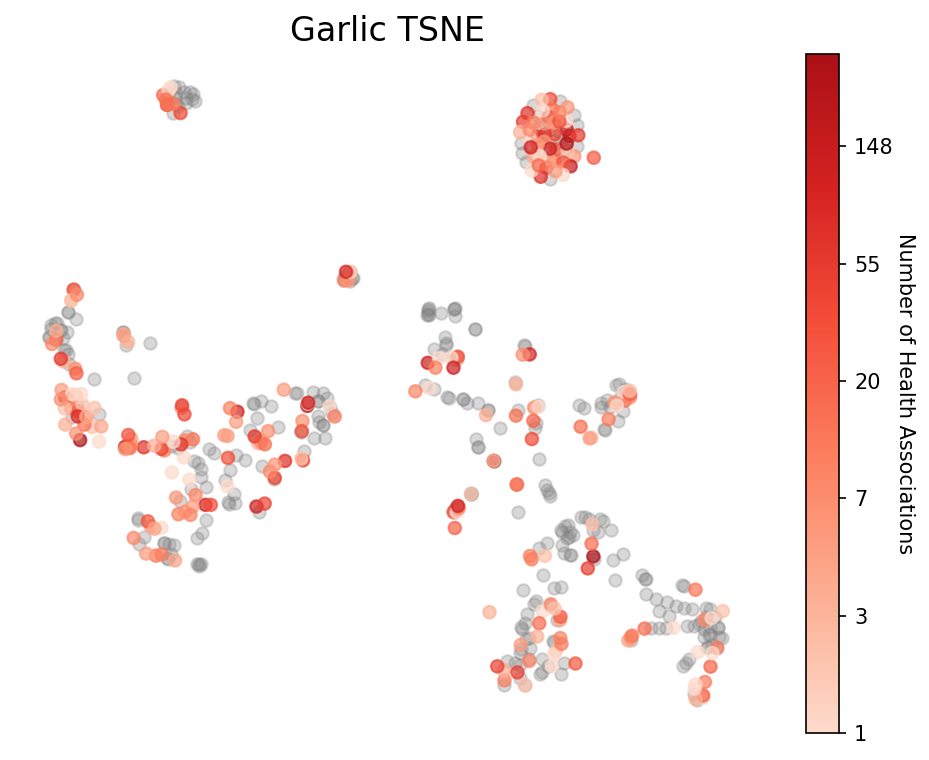

In [119]:
target_col = 'Number of Health Associations'

_, ax = plt.subplots(figsize=(8,6))

# Seperate 0 and non-zero data
v1 = viz_data[viz_data[target_col] != 0]
v2 = viz_data[viz_data[target_col] == 0]

color_values = v1[target_col].apply(np.log).tolist()
#color_values = v1[target_col].tolist()

#min_c_val = -11.6 # min(color_values) # Need to change to make colorbars same
#max_c_val = 11.3 #max(color_values)

min_c_val = min(color_values)
max_c_val = max(color_values)

levels = np.linspace(min_c_val, max_c_val, 10)

# Plot data with 0 in grey
ax.scatter(v2.tsne_0.tolist(), v2.tsne_1.tolist(), c='grey',
           marker='o', alpha=.3)

# Plot non-zero data accoring to color bar
f = ax.scatter(v1.tsne_0.tolist(), v1.tsne_1.tolist(), c=color_values,
           cmap=clr.LinearSegmentedColormap.from_list('map1', sns.color_palette("Reds").as_hex(), N=10000),
               marker='o', alpha=.7, vmin=min_c_val, vmax=max_c_val)

ax.set_title(f'{food.capitalize()} TSNE', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.axis('off')

cbar = plt.colorbar(f)
cbar.set_label(target_col, rotation=270, labelpad=+10)

ticks = cbar.get_ticks()
cbar.ax.set_yticklabels([int(round(np.exp(t))) for t in ticks])

138


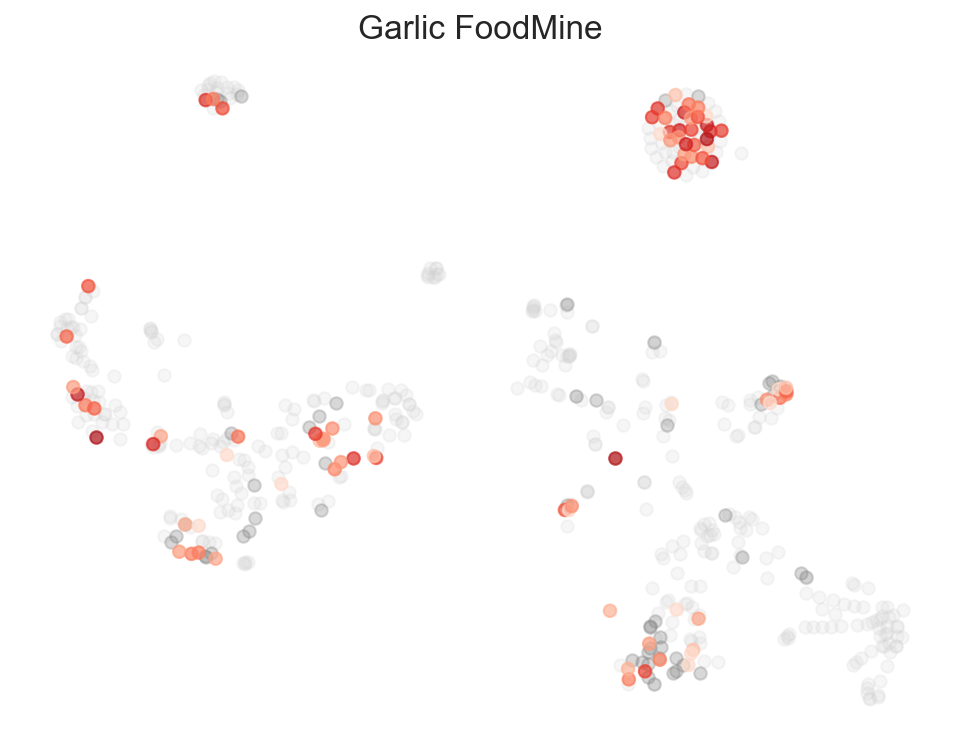

133


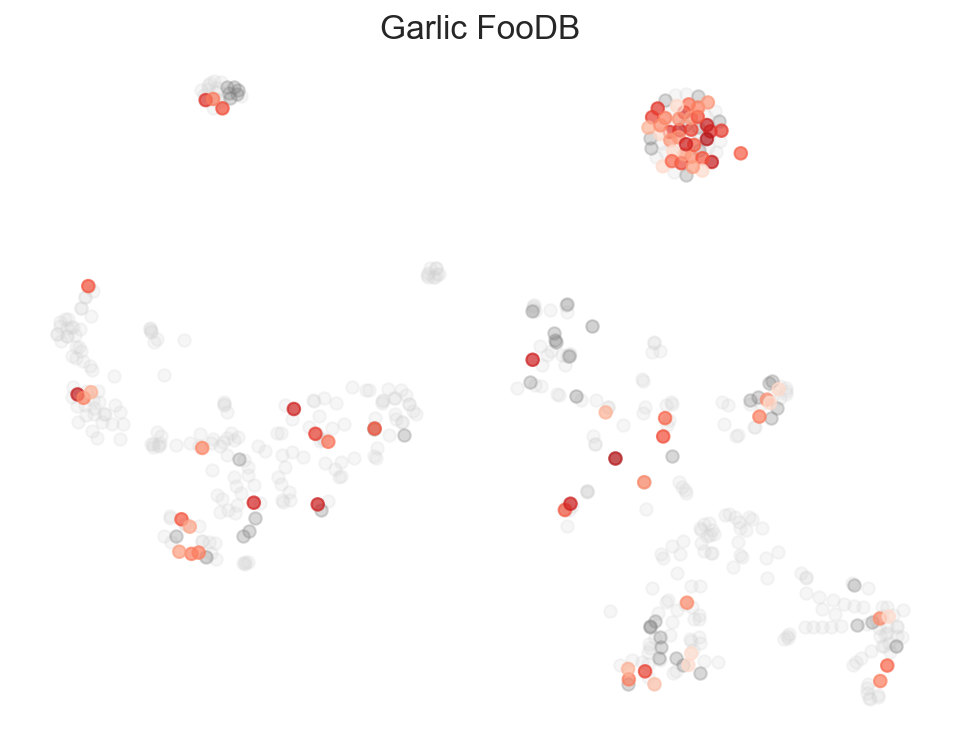

102


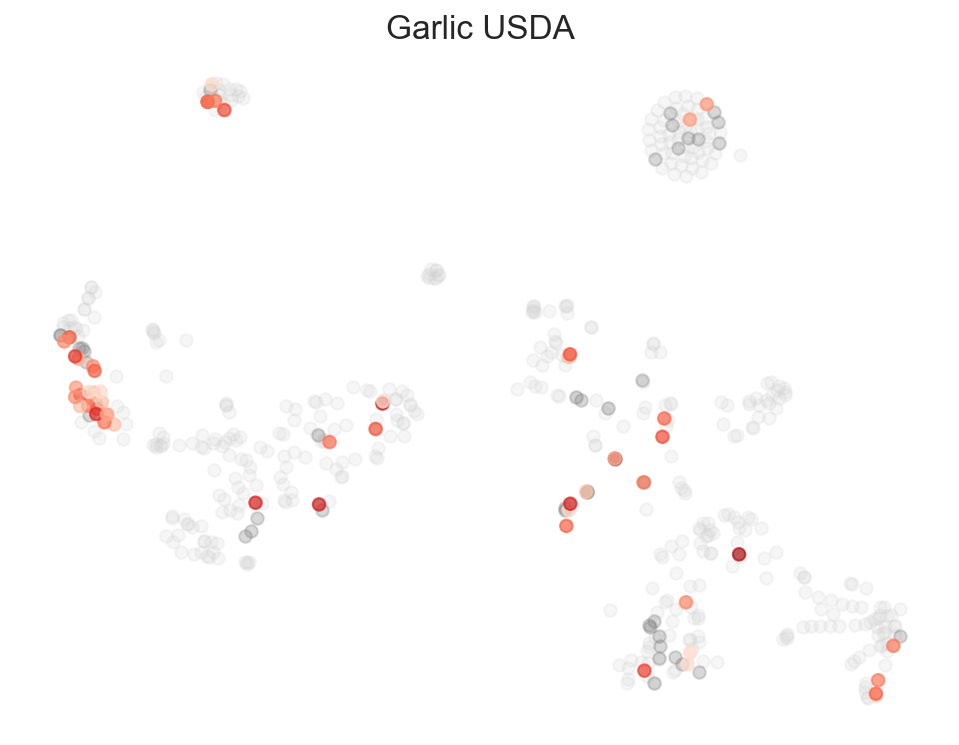

In [120]:
source_strings = ['FoodMine', 'FooDB', 'USDA']

main_color = 'Reds'
color_pals = {
    'FoodMine' : clr.LinearSegmentedColormap.from_list('map1', sns.color_palette(main_color).as_hex()),
    'FooDB' : clr.LinearSegmentedColormap.from_list('map2', sns.color_palette(main_color).as_hex()),
    'USDA' : clr.LinearSegmentedColormap.from_list('map3', sns.color_palette(main_color).as_hex())
}

# Plot each datasource as seperate graph
for s in source_strings:
    # Seperate values in datasource from values not in datasource
    # Null sources are chemicals that do occur in food plot, but occur in other food
    temp = viz_data[viz_data.source.fillna('NA').str.contains(s)]
    antitemp = viz_data[~viz_data.source.fillna('NA').str.contains(s)]
    
    print(len(temp))
    
    with sns.axes_style('white'):
        _, ax = plt.subplots(figsize=(8,6))

        color_values = temp[target_col].apply(np.log).tolist()
        
        # Plot values not in datasource as lightgrey
        ax.scatter(antitemp.tsne_0.tolist(), antitemp.tsne_1.tolist(), c='lightgrey',
                   marker='o', alpha=.2)

        v1 = temp[temp[target_col] != 0]
        v2 = temp[temp[target_col] == 0]

        color_values = v1[target_col].apply(np.log).tolist()
        
        # Plot values in datasource with a value of 0 as grey
        ax.scatter(v2.tsne_0.tolist(), v2.tsne_1.tolist(), c='grey',
                   marker='o', alpha=.3)
        
        # Plot values in datasource with a nonzero value in the colormap color
        f = ax.scatter(v1.tsne_0.tolist(), v1.tsne_1.tolist(), c=color_values,
                   cmap=color_pals[s], marker='o', alpha=.7, vmin=min_c_val, vmax=max_c_val)

        ax.set_title(food.capitalize() + ' ' + s, fontsize=16)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.axis('off')

        plt.show()

In [121]:
import colorcet as cc

def alter_classes(c, swap=None):
    if c in swap:
        return swap[c]
    else:
        return c

swap = {
    'organic oxygen compounds' : 'organic oxygen group',
    'organooxygen compounds' : 'organic oxygen group'
}

classdata = pd.concat([
    pd.read_pickle(f'data/garlic_chemical_viz_data.pkl'), pd.read_pickle(f'data/cocoa_chemical_viz_data.pkl')
], axis=0, ignore_index=True, sort=False)

class_labels = classdata['class'].str.lower().drop_duplicates().dropna().apply(alter_classes, swap=swap).tolist()
p = cc.glasbey_light[:len(class_labels)]

colors = {l : p[i] for i, l in enumerate(class_labels)}

c:\software\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\software\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


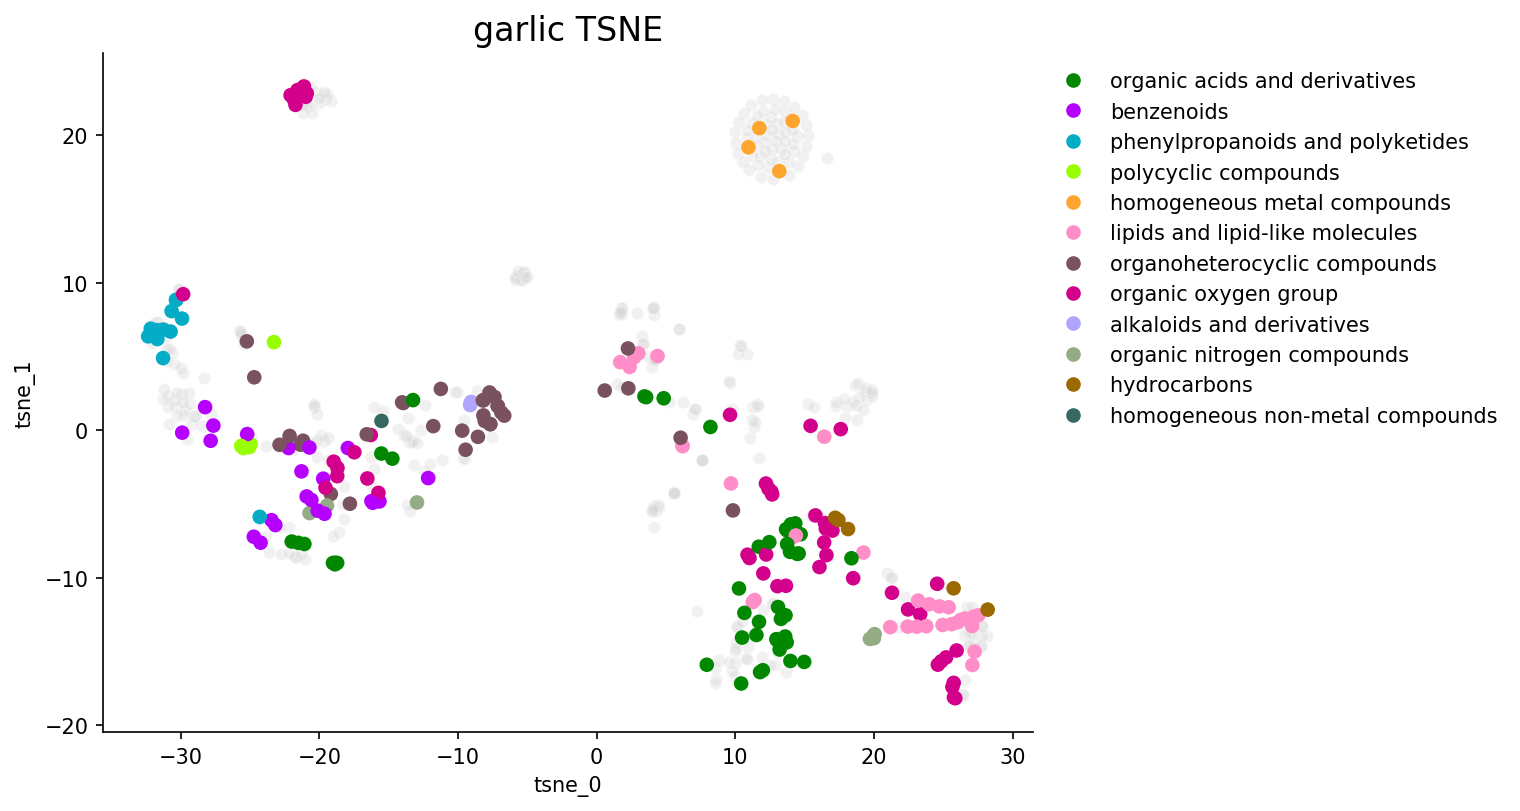

In [122]:
v1 = viz_data[viz_data['class'] != 'NA']
v2 = viz_data[viz_data['class'] == 'NA']

v1['class'] = v1['class'].apply(alter_classes, swap=swap)
v2['class'] = v2['class'].apply(alter_classes, swap=swap)

_, _ = plt.subplots(figsize=(8,6))

ax = sns.scatterplot(x='tsne_0', y='tsne_1', color='lightgrey', alpha=.3, data=v2)
ax.scatter(v1['tsne_0'].tolist(), v1['tsne_1'].tolist(), c=[colors[l] for l in v1['class'].tolist()])

ax.set_title(f'{food} TSNE', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

patches = [mpl.lines.Line2D([0], [0], color=colors[s], label=s, marker='o', linewidth=0) for s in v1['class'].drop_duplicates().tolist()]
ax.legend(handles = patches, frameon = False, loc='upper left', bbox_to_anchor=(1, 1))